## Оценка влияния фактора загрязнения на надежность компонента

#### Исходные данные: 
Файл failures.xlsx в котором указана наработка на отказ (столбец Hours) компонента в часах. В некоторых случаях при исследовании причины отказа было выявлено загрязнение (столбец Factor). 

#### Задача: 
1. Определить, влияет ли загрязнение на надежность компонента (MTBF - mean time between failures). 
2. Определить закон распределения отказов.
3. Определить 95% доверительный интервал средней наработки на отказ.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, ttest_ind, levene
import scipy.stats as st
import statsmodels.api as sm
import pandas
from patsy import dmatrices
from statsmodels.stats.power import TTestIndPower

In [2]:
failures_data = pd.read_excel(r'C:\Users\pletn\Documents\notebooks\failures.xlsx')
failures_data.head()

,Hours,Factor
0,6647,dirty
1,3340,dirty
2,5916,dirty
3,996,dirty
4,5630,dirty


In [3]:
failures_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Hours   44 non-null     int64 
 1   Factor  44 non-null     object
dtypes: int64(1), object(1)
memory usage: 832.0+ bytes


In [4]:
failures_data['Factor'].unique()

array(['dirty', 'without dirty'], dtype=object)

In [5]:
# Количество отказов с загрязнениями и без

failures_data.groupby('Factor').agg({'Hours' : 'count'}).rename(columns = {'Hours' : 'cont'})

,cont
Factor,
dirty,18
without dirty,26


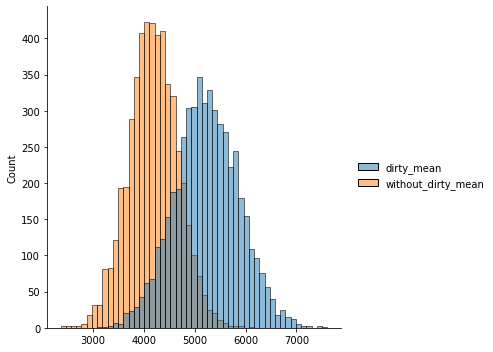

In [6]:
# Распределение средних MTBF на отказ в зависимости от фактора загрязнения 

dirty = failures_data.query('Factor == "dirty"')['Hours']
without_dirty = failures_data.query('Factor == "without dirty"')['Hours']

dirty_MTBF = []
without_dirty_MTBF = []

for i in range(5000):
    dirty_MTBF.append(dirty.sample(len(dirty), replace=True).mean())
    without_dirty_MTBF.append(without_dirty.sample(len(without_dirty), replace=True).mean())
    
MTBF_mean_dirty = pd.DataFrame(dirty_MTBF, columns = ['dirty_mean'])
MTBF_mean_without_dirty = pd.DataFrame(without_dirty_MTBF, columns = ['without_dirty_mean'])
sns.displot(pd.concat([MTBF_mean_dirty, MTBF_mean_without_dirty]));

### 1. Влияние загрязнения на надежность. 
Гипотеза Н0: MTBF загрязненных компонентов = MTBF без загрязнений, альтернативная H1: MTBF загрязненных компонентов != MTBF без загрязнений.

Проверка гипотезы будет происходить для $\alpha$ = 0.05.

Оценка возможности применения t-test:

In [7]:
# Проверка нормальности распределения средних MTBF загрязненных компонентов. alpha = 0.05.

shapiro(dirty_MTBF)

ShapiroResult(statistic=0.9995742440223694, pvalue=0.35381004214286804)

In [8]:
# Проверка нормальности распределения средних MTBF не загрязненных компонентов. aplpha = 0.05.

shapiro(without_dirty_MTBF)

ShapiroResult(statistic=0.9997126460075378, pvalue=0.7442430257797241)

In [9]:
# Проверка гомогенности дисперсий. alpha = 0.05.

levene(dirty, without_dirty)

LeveneResult(statistic=0.02851066779152972, pvalue=0.8667244008465008)

Условия для применения t-test выполняются. Распределение средних MTBF для клапанов с загрязнением подчиняется нормальному закону (p-value > $\alpha$), аналогично для клапанов без загрязнения. Дисперсии гомогенны (p-value > $\alpha$). 

In [10]:
ttest_ind(dirty, without_dirty)

Ttest_indResult(statistic=1.336408547093011, pvalue=0.1886110939394267)

In [11]:
# Определение мощности теста 

analysis = TTestIndPower()

effect_size = (dirty.mean() - without_dirty.mean()) / np.std(dirty)
nobs1 = failures_data.query('Factor == "dirty"').shape[0]
ratio = failures_data.query('Factor == "without dirty"').shape[0] /\
        failures_data.query('Factor == "dirty"').shape[0]
df = failures_data.shape[0] - 2

result = analysis.power(effect_size = effect_size, nobs1 = nobs1, alpha = 0.05, ratio = ratio, 
                        df = df, alternative='two-sided')

print(result)

0.24635656311166715


### 2. Определение закона распределения для отказов клапанов
Проверим гипотезу Н0 о том, что отказы компонента подчиняются нормальному распределению. $\alpha$ = 0.05.

In [12]:
shapiro(failures_data['Hours'])

ShapiroResult(statistic=0.9759389758110046, pvalue=0.48009565472602844)

In [13]:
print('Среднее значение наработки = ', round(failures_data['Hours'].mean()), 
      'Стандартное отклонение = ', round(np.std(failures_data['Hours'])))

Среднее значение наработки =  4598 Стандартное отклонение =  2599


### 3. Определение доверительного интервала MTBF.

In [14]:
st.t.interval(alpha=0.95, df=len(failures_data['Hours'])-1, 
              loc=np.mean(failures_data['Hours']), 
              scale=st.sem(failures_data['Hours'])) 

(3798.586161769141, 5397.232020049041)

# Выводы:

1. При проверке гипотезы о равенстве MTBF p-value = 0.188 > $\alpha$ 0.05. При этом мощность теста составила всего 25%. Соответственно можно говорить о недостаточности данных для вывода о какой то гипотезе с адекватной вероятностью ошибки.
2. Отказы PRSOV подчиняются нормальному закону распределения со средним 4597 л.ч. и стандартным отклонением 2599 л.ч.
3. 95% доверительный интервал для MTBF составляет (3798, 5397).